In [1]:
magma_dir = '/home/marco/epfl/magma/'

#### Init

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from textwrap import fill
import random

## **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Output directory
OUTPUT_PATH = magma_dir+'summarization/compare_results/'

MODELS = {}

## **Function Definition**

In [4]:
def plot_compare_rouge(df_path_list, method_list, rouge):
    df_list = []
    for df_path in df_path_list:
        df_list.append(pd.read_csv(df_path).set_index(['book', 'chapter']))
    
    num_df = len(df_list)
    
    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_df))

    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)

    xticks = 2*np.array(np.arange(1, len(config.ROUGE_TYPES)+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for df, m, var in\
        zip(df_list, method_list, np.linspace(-0.15*num_df, 0.15*num_df, num_df)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+stat].tolist() for stat in ['precision', 'recall', 'fmeasure']],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=method_list[i])
    plt.legend(loc='upper right')

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Comparison '+rouge, fontsize='xx-large')
    ax.set_ylabel(rouge, fontsize='x-large')
    #plt.yticks(np.linspace(0, 100, 21))
    plt.xticks(xticks, ['precision', 'recall', 'fmeasure'], fontsize='x-large')
    plt.show()

In [5]:
def plot_compare_wordembed(df_path_list, method_list):
    df_list = []
    for df_path in df_path_list:
        df_list.append(pd.read_csv(df_path).set_index(['book', 'chapter']))
    
    num_df = len(df_list)
    
    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_df))

    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)

    xticks = 2*np.array(np.arange(1, 3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for df, m, var in\
        zip(df_list, method_list, np.linspace(-0.15*num_df, 0.15*num_df, num_df)):
    
        box_plt_list.append(
            plt.boxplot(
            [df['st_cosine_sim'].tolist(), df['w2v_cosine_sim'].tolist()],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=method_list[i])
    plt.legend(loc='upper right')

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Comparison Embedding Cosine Similrity', fontsize='xx-large')
    plt.xticks(xticks, ['Sentence Transformer', 'Word 2 Vec'], fontsize='x-large')
    plt.show()

## **Bullet - Para Match (BPM) Dataset (rouge)**

#### Bullet by bullet
#### DistilBART-CNN vs PEGASUS vs T5

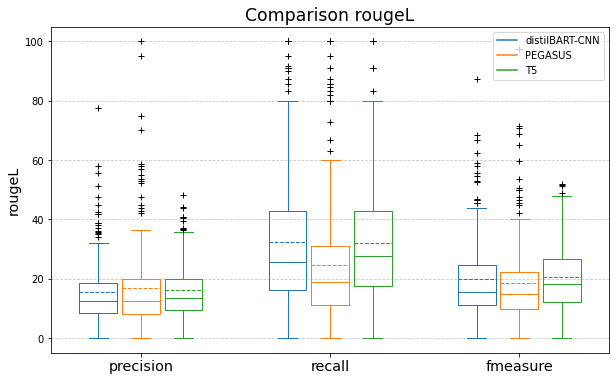

In [6]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_rouge/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_rouge/pegasus/'+\
         'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_rouge/t5/'+\
         't5-large_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'PEGASUS',
    'T5'],
    
    'rougeL')

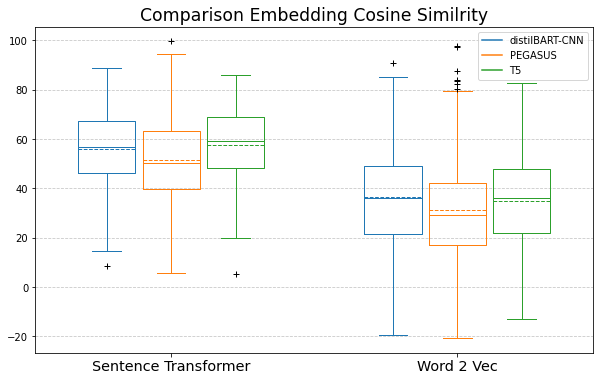

In [7]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_rouge/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_rouge/pegasus/'+\
         'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_rouge/t5/'+\
         't5-large_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'PEGASUS',
    'T5']
)

#### Bullet by bullet
#### DistilBART-CNN on BPM Rouge vs BPM Sentence Trans

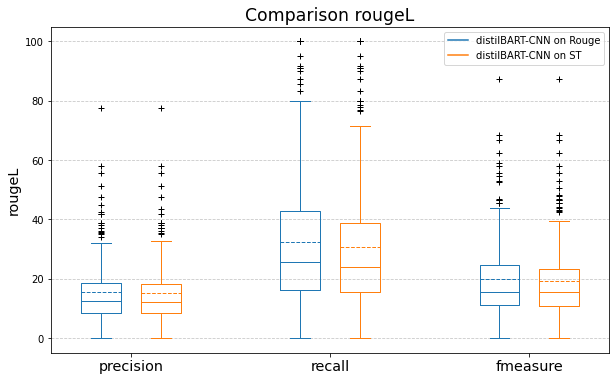

In [31]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_rouge/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv'],
    
    ['distilBART-CNN on Rouge',
    'distilBART-CNN on ST'],
    
    'rougeL')

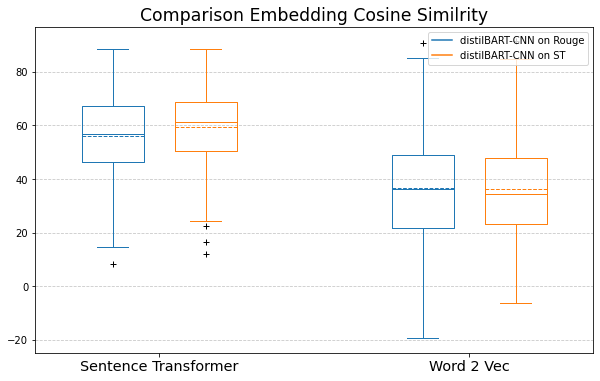

In [32]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_rouge/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv'],
    
    ['distilBART-CNN on Rouge',
    'distilBART-CNN on ST'])

#### Bullet by bullet
#### PEGASUS on BP match Rouge vs BP match Sentence Trans

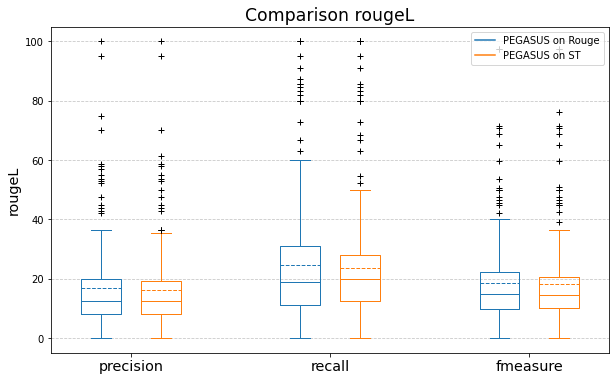

In [33]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_rouge/pegasus/'+\
        'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/pegasus/'+\
        'google?pegasus-large_bullet_by_bullet.csv'],
    
    ['PEGASUS on Rouge',
    'PEGASUS on ST'],
    
    'rougeL')

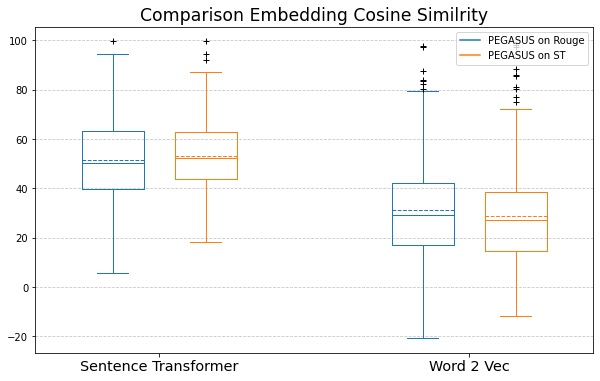

In [34]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_rouge/pegasus/'+\
        'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/pegasus/'+\
        'google?pegasus-large_bullet_by_bullet.csv'],
    
    ['PEGASUS on Rouge',
    'PEGASUS on ST'])

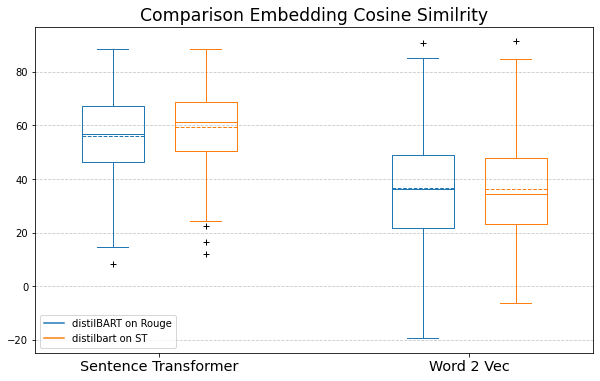

## **Bullet - Para Match (BPM) Dataset (sentence transformer)**

#### Bullet by bullet
#### DistilBART-CNN vs PEGASUS vs T5

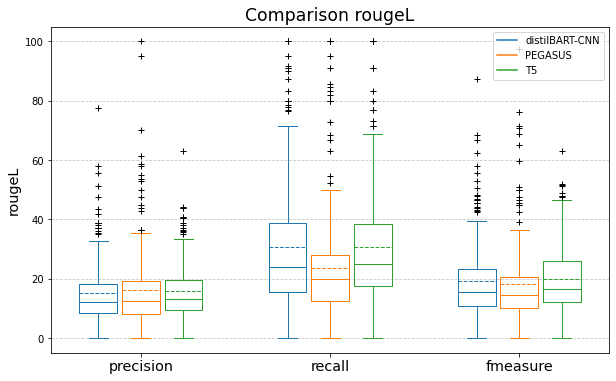

In [8]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/pegasus/'+\
         'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/t5/'+\
         't5-large_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'PEGASUS',
    'T5'],
    
    'rougeL')

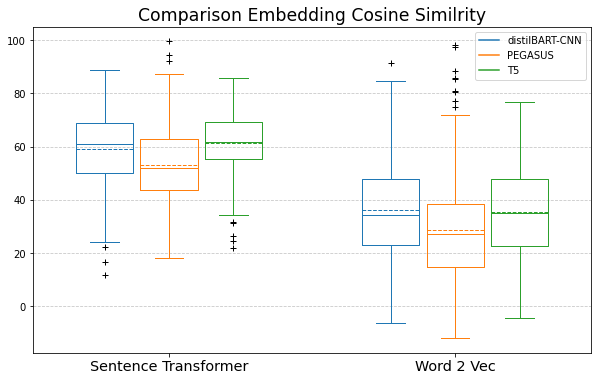

In [9]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/pegasus/'+\
         'google?pegasus-large_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/t5/'+\
         't5-large_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'PEGASUS',
    'T5']
)

#### Bullet by bullet
#### distilBART-CNN vs distilBART-CNN FT freezed vs distilBART-CNN FT

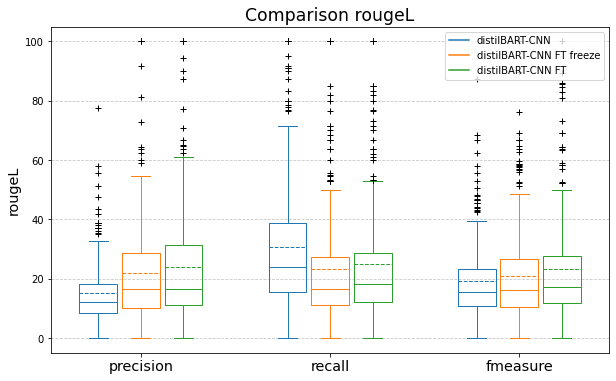

In [37]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'distilBART-CNN FT freeze',
    'distilBART-CNN FT'],
    
    'rougeL')

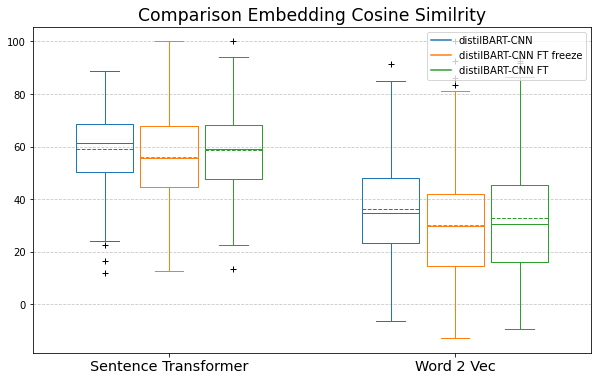

In [38]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_bullet_by_bullet.csv'],
    
    ['distilBART-CNN',
    'distilBART-CNN FT freeze',
    'distilBART-CNN FT'])

In [72]:
distilBART_BPM_st = pd.read_csv(magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
    'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv').set_index(['book', 'chapter', 'bullets'])
distilBART_FT_BPM_st = pd.read_csv(magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
    'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_bullet_by_bullet.csv').set_index(['book', 'chapter', 'bullets'])

distilBART_BPM_st =\
distilBART_BPM_st.join(distilBART_FT_BPM_st, on=['book', 'chapter', 'bullets'], lsuffix='_base', rsuffix='_ft')
distilBART_BPM_st = distilBART_BPM_st.reset_index(level=2)

distilBART_BPM_st['st_distance'] = distilBART_BPM_st['st_cosine_sim_ft'] - distilBART_BPM_st['st_cosine_sim_base']
distilBART_BPM_st['w2v_distance'] = distilBART_BPM_st['w2v_cosine_sim_ft'] - distilBART_BPM_st['w2v_cosine_sim_base']
print('Sentence Transformer cosine similarity distance between base model and FT. Negative values mean the FT'+\
     ' model is performing worse than the base model:')
print(distilBART_BPM_st['st_distance'].describe())
print('\nW2V cosine similarity distance between base model and FT. Negative values mean the FT'+\
     ' model is performing worse than the base model:')
print(distilBART_BPM_st['w2v_distance'].describe())

Sentence Transformer cosine similarity distance between base model and FT. Negative values mean the FT model is performing worse than the base model:
count    242.000000
mean      -0.661262
std       15.186941
min      -39.097878
25%       -9.150788
50%       -1.090734
75%        6.527868
max       52.434176
Name: st_distance, dtype: float64

W2V cosine similarity distance between base model and FT. Negative values mean the FT model is performing worse than the base model:
count    242.000000
mean      -3.266002
std       20.680001
min      -59.752486
25%      -14.580168
50%       -2.971531
75%        7.429814
max       79.651324
Name: w2v_distance, dtype: float64


In [73]:
worse_st_examples = distilBART_BPM_st.sort_values(by='st_distance', ascending=True)[:10]
for idx, r in worse_st_examples.iterrows():
    print(fill(r.text_base, 100))
    print('\nReference:')
    print(fill(r.bullets, 100))
    print('\ndistilBART base (ST sim %.2f):'%r.st_cosine_sim_base)
    print(fill(r.summary_base, 100))
    print('\ndistilBART ft (ST sim %.2f):'%r.st_cosine_sim_ft)
    print(fill(r.summary_ft, 100))
    print('\n'+(''.join(['#']*100)+'\n'))

Recurrent presyncope (the sensation patients describe when they feel they are about to lose
consciousness) is common and may culminate in syncope over time. Presyncope occurs commonly in
situations where the native cardiac pacemaker is impaired but not for long enough to produce syncope
(exempli gratia sick sinus syndrome or carotid sinus hypersensitivity). Self-injury is variable. In
some cases, symptoms may occur over many years before a diagnosis is made. In many cases, specific
precipitating factors are uncommon. Presyncope needs to be differentiated from dizziness, which can
include vertigo. Syncope in patients with known structural heart disease, particularly impaired left
ventricular (LV) function, carries a significantly worse prognosis with an increased risk of sudden
death. Syncope may be due to sustained ventricular tachycardia (VT), or intermittent advanced heart
block. These patients require urgent cardiological investigation.

Reference:
Syncope in patients with known str

In [71]:
worse_st_examples = distilBART_BPM_st.sort_values(by='w2v_distance', ascending=True)[:10]
for idx, r in worse_st_examples.iterrows():
    print('Reference:')
    print(fill(r.bullets, 100))
    print('\ndistilBART base (W2V sim %.2f):'%r.w2v_cosine_sim_base)
    print(fill(r.summary_base, 100))
    print('\ndistilBART ft (W2V sim %.2f):'%r.w2v_cosine_sim_ft)
    print(fill(r.summary_ft, 100))
    print('\n'+(''.join(['#']*100)+'\n'))

Reference:
Long-term survival of patients with AML is poor: about a quarter of patients survive 5 years but
only 10% of older patients.

distilBART base (W2V sim 68.36):
 AML is universally fatal if untreated. Even with treatment, patients seldom survive long term: only
27% of patients survive 5 years from diagnosis. Survival is particularly poor in older patients,
with fewer than 10% surviving 5 years.

distilBART ft (W2V sim 8.61):
 AML is universally fatal if untreated.

####################################################################################################

Reference:
Acquired PK deficiency very rarely can occur secondarily to other blood diseases.

distilBART base (W2V sim 70.85):
 Acquired form of PK deficiency can very rarely occur secondarily to other blood diseases, such as
acute leukemia, myelodysplastic syndrome and refractory sideroblastic anemia. Acquired PK deficiency
can also result from complications associated with chemotherapy.

distilBART ft (W2V sim 12.

#### Grouping bullets
#### distilBART-CNN vs distilBART-CNN FT freezed vs distilBART-CNN FT

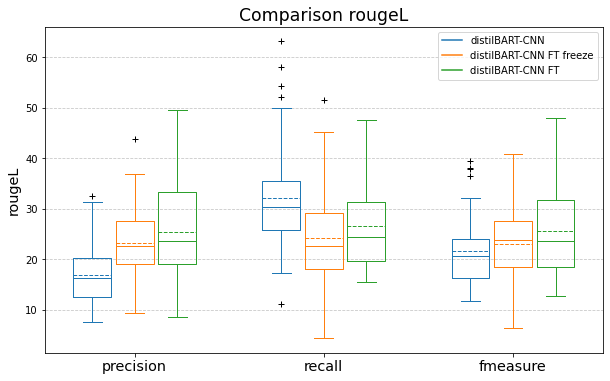

In [21]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?_grouped.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_grouped.csv'],
    
    ['distilBART-CNN',
    'distilBART-CNN FT freeze',
    'distilBART-CNN FT'],
    
    'rougeL')

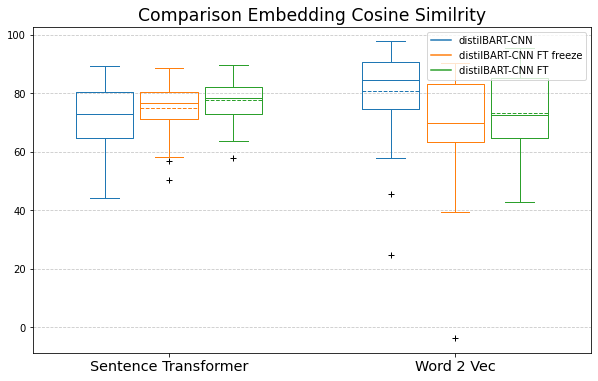

In [39]:
plot_compare_wordembed(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?_grouped.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_grouped.csv'],
    
    ['distilBART-CNN',
    'distilBART-CNN FT freeze',
    'distilBART-CNN FT'])

## **Full Dataset**

#### Chunk Chapter grouping bullets
#### Distilbart vs Recurrent Decoder vs LED

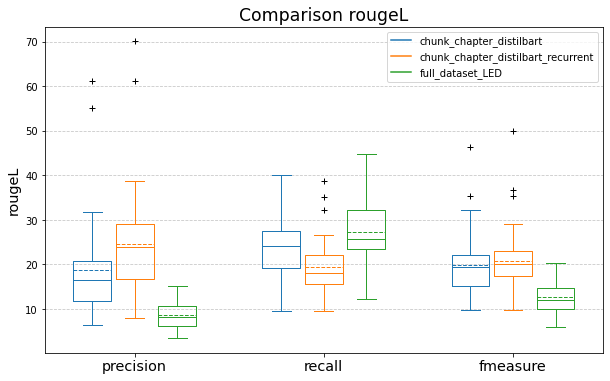

In [74]:
plot_compare_rouge(
    [magma_dir+'summarization/baseline_output/bart/sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/recurrent_decoder_cc/bart/sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/karger_books_base/led/allenai?led-base-16384_grouped.csv'],
    
    ['chunk_chapter_distilbart',
    'chunk_chapter_distilbart_recurrent',
    'full_dataset_LED'],
    
    'rougeL')

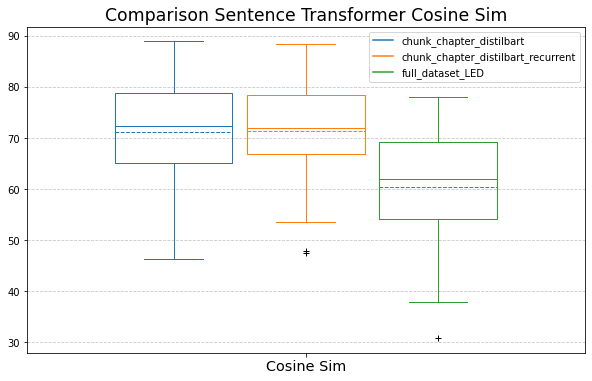

In [32]:
plot_compare_sentence_trans(
    [magma_dir+'summarization/baseline_output/bart/sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/recurrent_decoder_cc/bart/sshleifer?distilbart-cnn-12-6_grouped.csv',
    magma_dir+'summarization/karger_books_base/led/allenai?led-base-16384_grouped.csv'],
    
    ['chunk_chapter_distilbart',
    'chunk_chapter_distilbart_recurrent',
    'full_dataset_LED'])